# Import Packages

In [11]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
# try:
#     import pyadts
# except:
#     !pip install pyadts

In [13]:
import sys
sys.path.append('..')

In [14]:
from pyadts.data.repository import get_kpi, get_custom_dataset

# Prepare Data & Pre-processing

In [15]:
data_df, meta_df = get_kpi(root_path='../tests/data/kpi', kpi_id=1)
# BASE_PATH = '../tests/data/travelsky'
# DATA_ID = 11
# data_list = os.listdir(BASE_PATH)
# print('Using', os.path.join(BASE_PATH, data_list[DATA_ID]), '...')
# data_df, meta_df = get_custom_dataset(os.path.join(BASE_PATH, data_list[DATA_ID]))
# data_df.head()

In [16]:
from pyadts.data.preprocessing import series_rearrange
from pyadts.data.preprocessing import series_impute
from pyadts.data.preprocessing import series_normalize

In [17]:
data_df, meta_df = series_rearrange(data_df, meta_df)

[INFO] Before processing, the shape of data: (17568, 1).
[INFO] Detected minimum interval: 0 days 00:05:00.
[INFO] After processing, the shape of data: (17568, 1).


In [18]:
from pyadts.utils.visualization import plot_series

<ipython-input-19-52caadc0f650>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


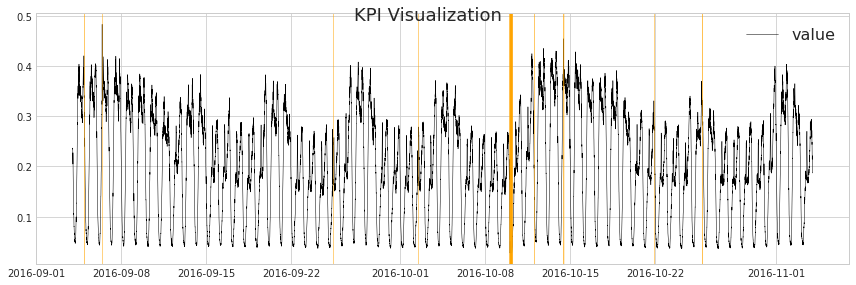

In [19]:
%matplotlib inline
fig = plot_series(data_df, meta_df, title='KPI Visualization')
fig.show()


In [20]:
series_impute(data_df, method='linear')
series_normalize(data_df, method='zscore')

NameError: name 'np' is not defined

In [ ]:
fig = plot_series(data_df, meta_df, title='KPI Processed Visualization', anomaly_color_depth=0.5)
fig.show()

# Feature Extraction

In [ ]:
from pyadts.data.feature import get_all_features

In [ ]:
features = get_all_features(data_df, get_stl=False, window_list=[5, 10, 24])

In [ ]:
features.shape

In [ ]:
meta_df = meta_df.iloc[-features.shape[0]:, :]

# Pre-processing and Feature Selection

In [ ]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

In [ ]:
print(f'Before processing, the shape of feature is {features.shape}')

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
from pyadts.data.utils import train_test_split
from sklearn.model_selection import train_test_split

In [ ]:
X = features.values
# X = MinMaxScaler().fit_transform(X)

In [ ]:
Y = meta_df['label'].values.reshape(-1)

In [ ]:
X = MinMaxScaler().fit_transform(X)

In [ ]:
sel = SelectKBest(mutual_info_classif, k=35)
X = sel.fit_transform(X, Y)
print(f'After processing, the shape of feature is {X.shape}')

In [ ]:
print(f'Selected features: {sel.get_support()}')

In [ ]:
# train_x, test_x, train_y, test_y = train_test_split(X, Y, train_size=0.5)

In [ ]:
train_x, test_x = X[:X.shape[0]//2], X[X.shape[0]//2:]
train_y, test_y = Y[:Y.shape[0]//2], Y[Y.shape[0]//2:]

# Evaluation

In [346]:
from pyadts.evaluation.metrics import roc_auc, pr_auc, best_f1, best_precision, best_recall

## XGBoost

In [347]:
import xgboost as xgb

In [348]:
train_matrix = xgb.DMatrix(train_x, label=train_y)

In [349]:
param = {'max_depth':10, 'eta':1, 'objective':'binary:logistic', 'scale_pos_weight': 30}
num_round = 2

In [350]:
bst = xgb.train(param, train_matrix, num_round)

In [351]:
test_matrix = xgb.DMatrix(test_x)

In [352]:
scores = bst.predict(test_matrix)

In [353]:
scores.shape

(251,)

In [354]:
test_y.shape

(251,)

In [355]:
res_df = {'roc': [roc_auc(scores, test_y)], 'roc_delay': [roc_auc(scores, test_y, delay=7)], 
          'pr': [pr_auc(scores, test_y)], 'pr_delay': [pr_auc(scores, test_y, delay=7)], 
          'f1': [best_f1(scores, test_y)], 'f1_delay': [best_f1(scores, test_y, delay=7)]}
res_df = pd.DataFrame(res_df)

D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function best_f1 is deprecated; Using F1-score to evaluate anomaly detection algorithms is not recommended.
  warnings.warn(msg, category=FutureWarning)


In [356]:
print(res_df)

        roc  roc_delay        pr  pr_delay        f1  f1_delay
0  0.860854    0.93107  0.572093   0.61668  0.714286     0.875


In [357]:
from pyadts.utils.visualization import plot_roc

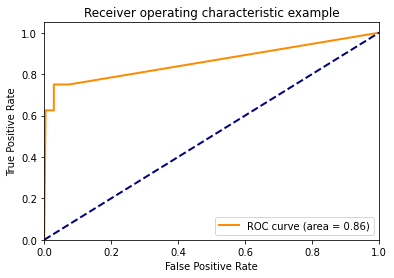

In [358]:
plot_roc(scores, test_y)

<ipython-input-359-816f5e961996>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


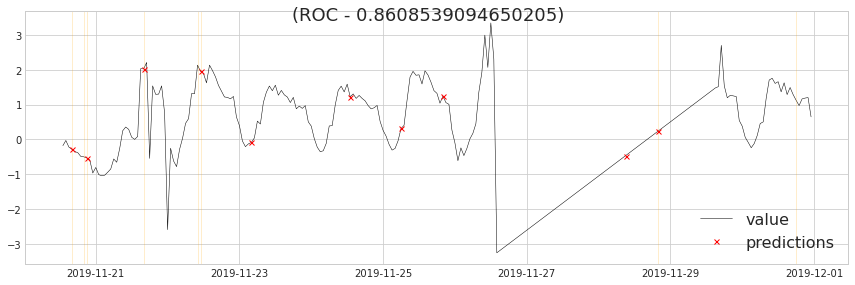

In [359]:
predictions = np.zeros_like(scores).astype(np.int)
predictions[scores>0.5] = 1
roc = roc_auc(scores, test_y)
fig = plot_series(data_df.iloc[-predictions.shape[0]:,:], pd.DataFrame({'label': test_y}), predictions=pd.DataFrame(predictions), title=f'(ROC - {roc})')
fig.show()

## LightGBM

In [375]:
import lightgbm as lgb

In [376]:
train_matrix = lgb.Dataset(train_x, label=train_y)

In [377]:
param = {'objective': 'binary', 'is_unbalance': true}

NameError: name 'true' is not defined

In [378]:
test_matrix = lgb.Dataset(test_x)

In [379]:
lbst = lgb.train(param, train_matrix)

In [380]:
scores = lbst.predict(test_x, num_iteration=lbst.best_iteration)

In [381]:
res_df = {'roc': [roc_auc(scores, test_y)], 'roc_delay': [roc_auc(scores, test_y, delay=7)], 
          'pr': [pr_auc(scores, test_y)], 'pr_delay': [pr_auc(scores, test_y, delay=7)], 
          'f1': [best_f1(scores, test_y)], 'f1_delay': [best_f1(scores, test_y, delay=7)]}
res_df = pd.DataFrame(res_df)

D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function best_f1 is deprecated; Using F1-score to evaluate anomaly detection algorithms is not recommended.
  warnings.warn(msg, category=FutureWarning)


In [382]:
print(res_df)

        roc  roc_delay        pr  pr_delay        f1  f1_delay
0  0.996914   0.996914  0.924621  0.924621  0.857143  0.857143


<ipython-input-383-816f5e961996>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


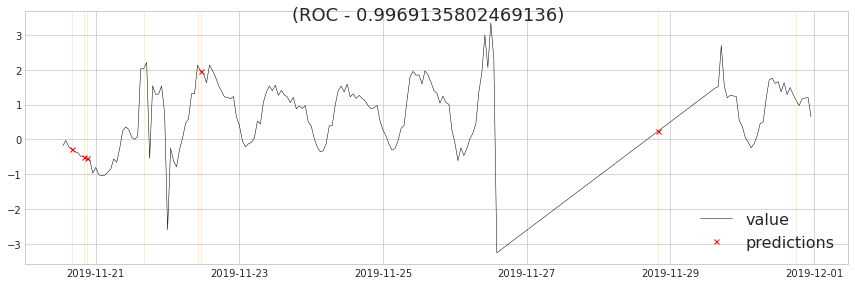

In [383]:
predictions = np.zeros_like(scores).astype(np.int)
predictions[scores>0.5] = 1
roc = roc_auc(scores, test_y)
fig = plot_series(data_df.iloc[-predictions.shape[0]:,:], pd.DataFrame({'label': test_y}), predictions=pd.DataFrame(predictions), title=f'(ROC - {roc})')
fig.show()

## Decision Tree

In [369]:
from sklearn.tree import DecisionTreeClassifier

In [370]:
dtree = DecisionTreeClassifier()

In [371]:
dtree.fit(train_x, train_y)

DecisionTreeClassifier()

In [372]:
scores = dtree.predict_proba(test_x)[:,1]

In [373]:
res_df = {'roc': [roc_auc(scores, test_y)], 'roc_delay': [roc_auc(scores, test_y, delay=7)], 
          'pr': [pr_auc(scores, test_y)], 'pr_delay': [pr_auc(scores, test_y, delay=7)], 
          'f1': [best_f1(scores, test_y)], 'f1_delay': [best_f1(scores, test_y, delay=7)]}
res_df = pd.DataFrame(res_df)

D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function best_f1 is deprecated; Using F1-score to evaluate anomaly detection algorithms is not recommended.
  warnings.warn(msg, category=FutureWarning)


In [374]:
print(res_df)

       roc  roc_delay        pr  pr_delay        f1  f1_delay
0  0.92927    0.92927  0.757674  0.757674  0.736842  0.736842


<ipython-input-324-816f5e961996>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


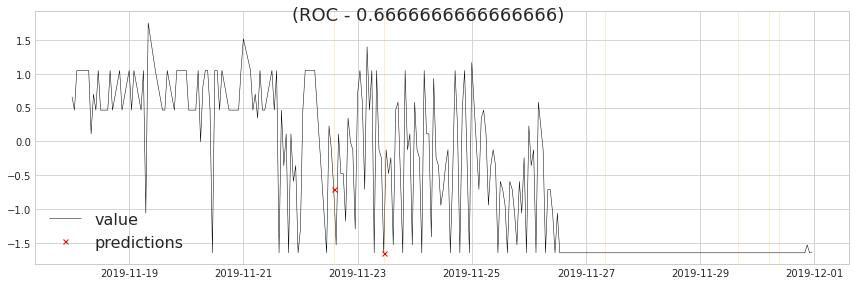

In [324]:
predictions = np.zeros_like(scores).astype(np.int)
predictions[scores>0.5] = 1
roc = roc_auc(scores, test_y)
fig = plot_series(data_df.iloc[-predictions.shape[0]:,:], pd.DataFrame({'label': test_y}), predictions=pd.DataFrame(predictions), title=f'(ROC - {roc})')
fig.show()

## SVC

In [253]:
from sklearn.svm import SVC

In [254]:
svc = SVC()

In [255]:
svc.fit(train_x, train_y)

SVC()

In [256]:
scores = svc.decision_function(test_x)

In [257]:
res_df = {'roc': [roc_auc(scores, test_y)], 'roc_delay': [roc_auc(scores, test_y, delay=7)], 
          'pr': [pr_auc(scores, test_y)], 'pr_delay': [pr_auc(scores, test_y, delay=7)], 
          'f1': [best_f1(scores, test_y)], 'f1_delay': [best_f1(scores, test_y, delay=7)]}
res_df = pd.DataFrame(res_df)

D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function best_f1 is deprecated; Using F1-score to evaluate anomaly detection algorithms is not recommended.
  warnings.warn(msg, category=FutureWarning)


In [258]:
print(res_df)

        roc  roc_delay        pr  pr_delay        f1  f1_delay
0  0.998095   0.998095  0.918333  0.918333  0.909091  0.909091


<ipython-input-259-816f5e961996>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


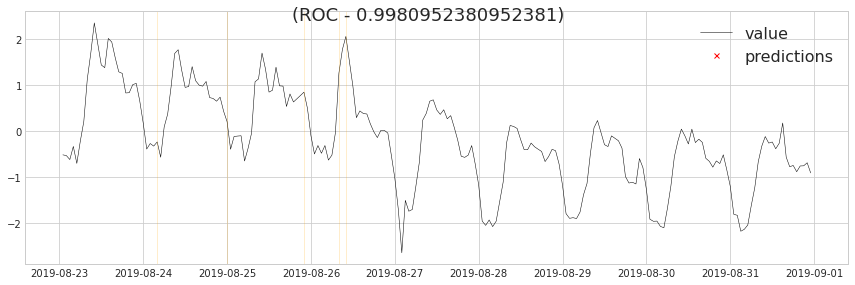

In [259]:
predictions = np.zeros_like(scores).astype(np.int)
predictions[scores>0.5] = 1
roc = roc_auc(scores, test_y)
fig = plot_series(data_df.iloc[-predictions.shape[0]:,:], pd.DataFrame({'label': test_y}), predictions=pd.DataFrame(predictions), title=f'(ROC - {roc})')
fig.show()

## Random Forest

In [260]:
from sklearn.ensemble import RandomForestClassifier

In [261]:
rf = RandomForestClassifier()

In [262]:
rf.fit(train_x, train_y)

RandomForestClassifier()

In [263]:
scores = rf.predict_proba(test_x)[:,1]

In [264]:
res_df = {'roc': [roc_auc(scores, test_y)], 'roc_delay': [roc_auc(scores, test_y, delay=7)], 
          'pr': [pr_auc(scores, test_y)], 'pr_delay': [pr_auc(scores, test_y, delay=7)], 
          'f1': [best_f1(scores, test_y)], 'f1_delay': [best_f1(scores, test_y, delay=7)]}
res_df = pd.DataFrame(res_df)

D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function best_f1 is deprecated; Using F1-score to evaluate anomaly detection algorithms is not recommended.
  warnings.warn(msg, category=FutureWarning)


In [265]:
print(res_df)

   roc  roc_delay   pr  pr_delay   f1  f1_delay
0  1.0        1.0  1.0       1.0  1.0       1.0


<ipython-input-266-816f5e961996>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


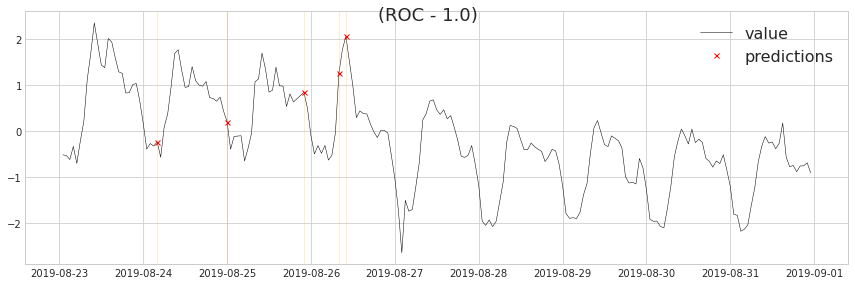

In [266]:
predictions = np.zeros_like(scores).astype(np.int)
predictions[scores>0.5] = 1
roc = roc_auc(scores, test_y)
fig = plot_series(data_df.iloc[-predictions.shape[0]:,:], pd.DataFrame({'label': test_y}), predictions=pd.DataFrame(predictions), title=f'(ROC - {roc})')
fig.show()

## MLP

In [267]:
from sklearn.neural_network import MLPClassifier

In [268]:
mlp = MLPClassifier()

In [269]:
mlp.fit(train_x, train_y)

D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

In [270]:
scores = mlp.predict_proba(test_x)[:,1]

In [271]:
res_df = {'roc': [roc_auc(scores, test_y)], 'roc_delay': [roc_auc(scores, test_y, delay=7)], 
          'pr': [pr_auc(scores, test_y)], 'pr_delay': [pr_auc(scores, test_y, delay=7)], 
          'f1': [best_f1(scores, test_y)], 'f1_delay': [best_f1(scores, test_y, delay=7)]}
res_df = pd.DataFrame(res_df)

D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function best_f1 is deprecated; Using F1-score to evaluate anomaly detection algorithms is not recommended.
  warnings.warn(msg, category=FutureWarning)


In [272]:
print(res_df)

        roc  roc_delay        pr  pr_delay   f1  f1_delay
0  0.995238   0.995238  0.860556  0.860556  0.8       0.8


<ipython-input-273-816f5e961996>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


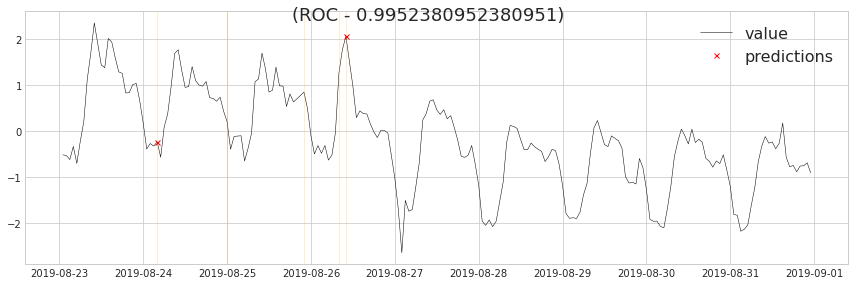

In [273]:
predictions = np.zeros_like(scores).astype(np.int)
predictions[scores>0.5] = 1
roc = roc_auc(scores, test_y)
fig = plot_series(data_df.iloc[-predictions.shape[0]:,:], pd.DataFrame({'label': test_y}), predictions=pd.DataFrame(predictions), title=f'(ROC - {roc})')
fig.show()